# SVRG и Катюша становятся лучше без внешнего цикла

## Постановка задачи

Рассмотрим задачу минимизации эмпирического риска:

$$ f(x) = \frac{1}{n} \sum_{i=1}^n f_i(x) \rightarrow \min_{x \in \mathbb{R}^d} \quad (1) $$

Такую задачу приходится решать в машинном обучении с учителем, и в таком контексте $n$ &mdash; это размер обучающей выборки, $x$ &mdash; вектор из $d$ параметров модели, а $f_i(x)$ &mdash; значение функции потерь на $i$-м объекте выборки при параметрах $x$.

## Loopless SVRG

### Описание алгоритма

**Вход:** размер шага $\eta > 0$, вероятность $p \in (0, 1]$, стартовая точка $x^0 \in \mathbb{R}^d$, количество итераций $K$.

$w^0 = x^0$ \
**for** $k = 0, 1, 2, \dots, K-1$ **do**: \
&nbsp; &nbsp; Выбрать $i$ случайно, равновероятно из $\{1, \dots, n\}$ \
&nbsp; &nbsp; $g^k = \nabla f_i(x^k) - \nabla f_i(w^k) + \nabla f(w^k)$ \
&nbsp; &nbsp; $x^{k+1} = x^k - \eta g^k$ \
&nbsp; &nbsp; $w^{k+1} = \cases{x^k \ \ \text{с вероятностью } p\\w^k \ \text{с вероятностью } 1-p}$ \
**end for**

**Выход:** $x_K$.

Классический SVRG отличается только тем, что $w^k$ обновляется не случайно, а во внешнем цикле: \
(Для упрощения восприятия не будем писать индексы, понимая знак равенства как оператор присваивания.)

**Вход:** размер шага $\eta > 0$, количество итераций внутреннего цикла $m$, стартовая точка $x \in \mathbb{R}^d$, количество итераций $K$.

**for** $k = 0, 1, 2, \dots, K-1$ **do**: \
&nbsp; &nbsp; $w = x$ \
&nbsp; &nbsp; **for** $t = 0, 1, 2, \dots, m - 1$ **do**: \
&nbsp; &nbsp; &nbsp; &nbsp; Выбрать $i$ случайно, равновероятно из $\{1, \dots, n\}$ \
&nbsp; &nbsp; &nbsp; &nbsp; $g = \nabla f_i(x) - \nabla f_i(w) + \nabla f(w)$ \
&nbsp; &nbsp; &nbsp; &nbsp; $x = x - \eta g$ \
&nbsp; &nbsp; **end for** \
**end for**

**Выход:** $x_K$.

## Loopless Katyusha (L-Katyusha)

### Описание алгоритма

**Вход:** $\theta_1$, $\theta_2$, вероятность $p \in (0, 1]$, стартовая точка $y^0 \in \mathbb{R}^d$, количество итераций $K$.

$\displaystyle \eta = \frac{\theta_2}{(1 + \theta_2)\theta_1}$ (размер шага) TODO: проверить\
$\displaystyle \sigma = \frac{\mu}{L}$ ($\mu, L$ &mdash; константа сильной выпуклости и константа Липшица градиента соответственно) \
$w^0 = z^0 = y^0$ \
**for** $k = 0, 1, 2, \dots, K-1$ **do**: \
&nbsp; &nbsp; $x^k = \theta_1 z^k + \theta_2 w^k + (1 - \theta_1 - \theta_2) y^k$ \
&nbsp; &nbsp; Выбрать $i$ случайно, равновероятно из $\{1, \dots, n\}$ \
&nbsp; &nbsp; $g^k = \nabla f_i(x^k) - \nabla f_i(w^k) + \nabla f(w^k)$ \
&nbsp; &nbsp; $z^{k+1} = \frac{1}{1 + \eta \sigma}\left( \eta \sigma x^k + z^k - \frac{\eta}{L} g^k \right)$ \
&nbsp; &nbsp; $y^{k+1} = x^k + \theta_1 (z^{k+1} - z^k)$ \
&nbsp; &nbsp; $w^{k+1} = \cases{y^k \ \ \text{с вероятностью } p\\w^k \ \text{с вероятностью } 1-p}$ \
**end for**

**Выход:** $y_K$. TODO: проверить

Классическая Катюша, аналогично, отличается только тем, что $w^k$ обновляется не случайно, а во внешнем цикле.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# import jax
# import jax.numpy as jnp
# import scipy.stats as sps

In [3]:
def SVRG(n, grad, outer_num_iter, x_0, stepsize, m, rng):
    x = x_0.copy()
    xs = [x.copy()]

    for k in tqdm(range(outer_num_iter)):
        # нам не нужно хранить w, только градиент в ней
        grads_w = np.array([grad(i, x) for i in range(n)])
        grad_w = grads_w.mean()

        for t in range(m):
            i = rng.integers(n)
            g = grad(i, x) - grads_w[i] + grad_w
            x -= stepsize * g
            xs.append(x.copy())

    return np.array(xs)

In [5]:
def L_SVRG(n, grad, num_iter, x_0, stepsize, p, rng):
    x = x_0.copy()
    xs = [x.copy()]

    grads_w = np.array([grad(i, x) for i in range(n)])
    grad_w = grads_w.mean()

    for k in tqdm(range(num_iter)):
        i = rng.integers(n)
        g = grad(i, x) - grads_w[i] + grad_w

        if rng.binomial(n=1, p=p):
            grads_w = np.array([grad(i, x) for i in range(n)])
            grad_w = grads_w.mean()

        x -= stepsize * g
        xs.append(x.copy())

    return np.array(xs)

In [4]:
def Katyusha(n, grad, outer_num_iter, y_0, t1, t2, m, mu, L, rng):
    eta = t2 / (1 + t2) / t1
    sigma = mu / L

    y = y_0.copy()
    ys = [y.copy()]
    z = y.copy()
    
    for k in tqdm(range(outer_num_iter)):
        w = y.copy()
        grads_w = np.array([grad(i, w) for i in range(n)])
        grad_w = grads_w.mean()
        
        for t in range(m):
            x = t1 * z + t2 * w + (1 - t1 - t2) * y

            i = rng.integers(n)
            g = grad(i, x) - grads_w[i] + grad_w

            new_z = (eta * sigma * x + z - eta / L * g) / (1 + eta * sigma)
            y = x + t1 * (new_z - z)
            ys.append(y.copy())
            z = new_z.copy()

    return np.array(ys)

In [6]:
def L_Katyusha(n, grad, num_iter, y_0, t1, t2, p, mu, L, rng):
    eta = t2 / (1 + t2) / t1
    sigma = mu / L

    y = y_0.copy()
    ys = [y.copy()]
    z = y.copy()

    w = y.copy()
    grads_w = np.array([grad(i, w) for i in range(n)])
    grad_w = grads_w.mean()

    for k in tqdm(range(num_iter)):
        x = t1 * z + t2 * w + (1 - t1 - t2) * y

        i = rng.integers(n)
        g = grad(i, x) - grads_w[i] + grad_w

        if rng.binomial(n=1, p=p):
            w = y.copy()
            grads_w = np.array([grad(i, w) for i in range(n)])
            grad_w = grads_w.mean()

        new_z = (eta * sigma * x + z - eta / L * g) / (1 + eta * sigma)
        y = x + t1 * (new_z - z)
        ys.append(y.copy())
        z = new_z.copy()

    return np.array(ys)

Игрушечный пример: $n = d$, $f_i(x) = \frac{i}{2} x_i^2,\ i=1,\dots,n$. \
$\nabla f_i(x) = i x_i e_i$

Константы сильной выпуклости и липшицевости градиента для $i$-ой функции: $\mu_i=i,\ L_i=i$. \
Значит, все функции являются $\mu$-сильно выпуклыми и $L$-гладкими для  $\mu=1,\ L=n$.

Тогда нужно брать TODO

In [7]:
def f_toy(i, x):
    return x[i]**2 * i / 2


def grad_toy(i, x):
    res = np.zeros_like(x)
    res[i] = i * x[i]
    return res

In [14]:
d = 20
n = d

rng = np.random.default_rng(3194312162)

init = 5 * np.ones(d)
xs_s = SVRG(n=d, grad=grad_toy, outer_num_iter=20, x_0=init, stepsize=0.1, m=n, rng=rng)
xs_ls = L_SVRG(n=n, grad=grad_toy, num_iter=400, x_0=init, stepsize=0.1, p=1/n, rng=rng)
xs_k = Katyusha(n=n, grad=grad_toy, outer_num_iter=20, y_0=init, t1=0.5, t2=0.5, m=n, mu=1, L=n, rng=rng)
xs_lk = L_Katyusha(n=n, grad=grad_toy, num_iter=400, y_0=init, t1=0.5, t2=0.5, p=1/n, mu=1, L=n, rng=rng)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

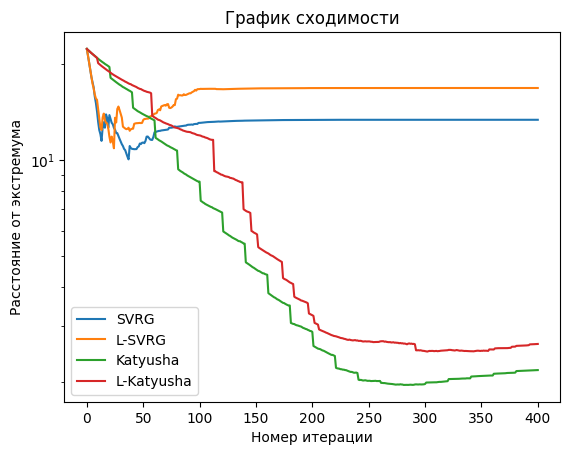

In [15]:
plt.plot(np.linalg.norm(xs_s, axis=1), label='SVRG')
plt.plot(np.linalg.norm(xs_ls, axis=1), label='L-SVRG')
plt.plot(np.linalg.norm(xs_k, axis=1), label='Katyusha')
plt.plot(np.linalg.norm(xs_lk, axis=1), label='L-Katyusha')
plt.yscale('log')
plt.title('График сходимости')
plt.xlabel('Номер итерации')
plt.ylabel('Расстояние от экстремума')
plt.legend()
plt.show()